# Demo the Arbitrageur Agent Logic

This notebook:

1. Fetches the latest crvusd contract data into Python objects using `crvusdsim`.
2. Fetches prices and `ExternalMarket`s from the `baseline` scenario.
3. Instantiates an Arbitrageur agent.
4. Checks if there are profitable arbitrages and performs them.

TODO describe the arbitrage logic in detail.

In [9]:
import cProfile
import pstats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
from src.sim.scenario import Scenario
from src.configs import MODELLED_MARKETS

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Generate markets and prices
scenario_ = Scenario("baseline", MODELLED_MARKETS)

[INFO][13:32:10][src.sim.scenario]-6678: Fetching wbtc market from subgraph
[INFO][13:32:15][src.sim.scenario]-6678: Market snapshot as 2024-01-16 22:24:59
[INFO][13:32:15][src.sim.scenario]-6678: Bands snapshot as 2024-01-15 19:58:47
[INFO][13:32:15][src.sim.scenario]-6678: Users snapshot as 2024-01-16 23:17:47
[INFO][13:32:15][src.sim.scenario]-6678: Fetching weth market from subgraph
[INFO][13:32:19][src.sim.scenario]-6678: Market snapshot as 2024-01-16 22:24:59
[INFO][13:32:19][src.sim.scenario]-6678: Bands snapshot as 2024-01-15 19:58:47
[INFO][13:32:19][src.sim.scenario]-6678: Users snapshot as 2024-01-16 23:17:47
[INFO][13:32:19][src.sim.scenario]-6678: Fetching sfrxeth market from subgraph
[INFO][13:32:25][src.sim.scenario]-6678: Market snapshot as 2024-01-16 22:24:59
[INFO][13:32:25][src.sim.scenario]-6678: Bands snapshot as 2024-01-15 19:58:47
[INFO][13:32:25][src.sim.scenario]-6678: Users snapshot as 2024-01-16 23:17:47
[INFO][13:32:25][src.sim.scenario]-6678: Fetching wstet

In [11]:
scenario = deepcopy(scenario_)

sample = scenario.curr_price
scenario._increment_timestamp(int(sample.timestamp.timestamp()))
scenario.prepare_for_trades(sample)  # Set External Market Price

# Unpack
markets = scenario.markets
pools = scenario.llammas
stableswap_pools = scenario.stableswap_pools
cycles = scenario.cycles
arbitrageur = scenario.arbitrageur

# Display available arbitrage cycles
cycles

[Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=crvUSD, amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDP, in=crvUSD, out=USDP, amt=0), Swap(pool=External Market (TUSD, USDP), in=Pax Dollar, out=TrueUSD, amt=0)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=crvUSD, amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=crvUSD, out=USDC, amt=0), Swap(pool=External Market (TUSD, USDC), in=USD Coin, out=TrueUSD, amt=0)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=crvUSD, amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDT, in=crvUSD, out=USDT, amt=0), Swap(pool=External Market (TUSD, USDT), in=Tether USD, out=TrueUSD, amt=0)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=crvUSD, amt=0), Swap(pool=Curve.fi Stablecoin WBTC, in=crvUSD, out=WBTC, amt=0), Swa

In [27]:
market.__dict__

{'coins': (TokenDTO(address='0x2260fac5e5542a773aa44fbcfedf7c193bc2c599', name='Wrapped BTC', symbol='WBTC', decimals=8, min_trade_size=0.03, max_trade_size=3000),
  TokenDTO(address='0xdac17f958d2ee523a2206206994597c13d831ec7', name='Tether USD', symbol='USDT', decimals=6, min_trade_size=1000.0, max_trade_size=100000000.0)),
 'pair_indices': [(0, 1), (1, 0)],
 'n': 2,
 'prices': {1: {0: 2.3898199875853506e-05}, 0: {1: 41844.15584415585}},
 'models': defaultdict(dict,
             {0: {1: IsotonicRegression(out_of_bounds='clip', y_max=1, y_min=0)},
              1: {0: IsotonicRegression(out_of_bounds='clip', y_max=1, y_min=0)}}),
 'coin_addresses': ['0x2260fac5e5542a773aa44fbcfedf7c193bc2c599',
  '0xdac17f958d2ee523a2206206994597c13d831ec7'],
 'name': 'External Market (WBTC, USDT)',
 'coin_names': ['Wrapped BTC', 'Tether USD'],
 'coin_decimals': [8, 6]}

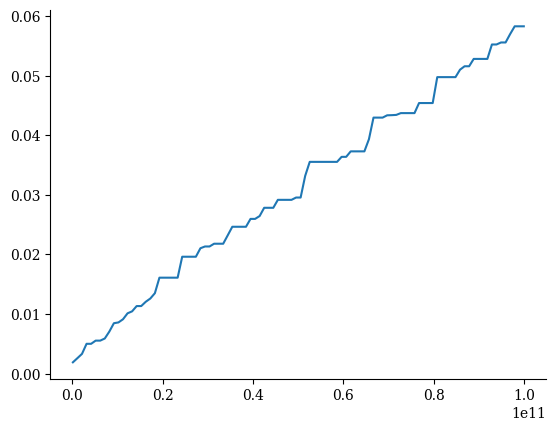

In [31]:
markets = list(scenario.markets.values())
market = markets[0]

i = 0
j = 1

xs = np.linspace(1e8, 1e11, 100)
ys = [market.price_impact(i, j, x) for x in xs]

plt.plot(xs, ys)

In [12]:
def simple_name(pool):
    if "External Market" in pool.name:
        return pool.name.replace("External Market", "EM")
    if "Curve.fi Factory Plain Pool:" in pool.name:
        return pool.name.replace("Curve.fi Factory Plain Pool:", "SS")
    if "Curve.fi Stablecoin" in pool.name:
        return pool.name.replace("Curve.fi Stablecoin", "Stable")


graph_hashmap = {
    simple_name(k): [simple_name(v) for v in vs]
    for k, vs in scenario.graph.graph.items()
}

G = nx.Graph()
for node, edges in graph_hashmap.items():
    for edge in edges:
        G.add_edge(node, edge)

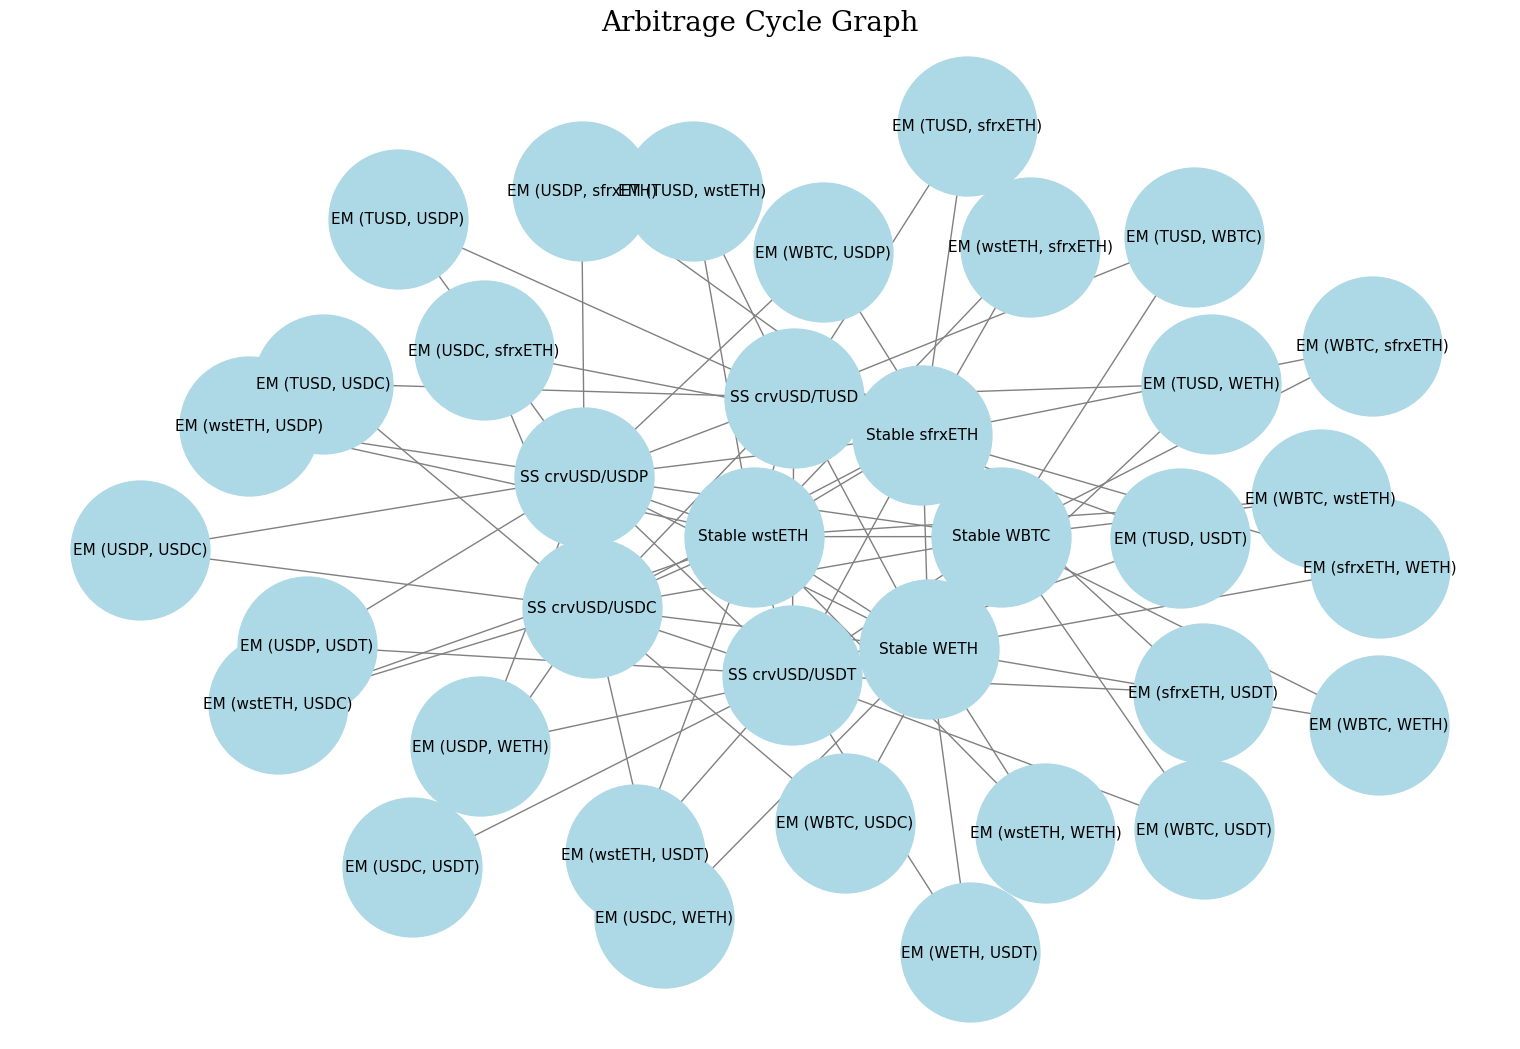

In [13]:
plt.figure(figsize=(15, 10))
pos = nx.kamada_kawai_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    edge_color="gray",
    font_size=11,
    node_size=10000,
)
plt.title("Arbitrage Cycle Graph", size=20)
plt.show()

# Show that arbitrage cycle optimization finds the most profitable arbitrage

The `cycle.optimize()` method will find the `amt_in` to the first trade in a `Cycle` that maximizes the `Cycle`'s profit. We plot `cycle.optimize()` against the profits from a simple `np.linspace` to show it converges to the maximum. The dataframe below also tells the same story.

In [14]:
df = pd.DataFrame(
    columns=["amt_optimize", "amt_linspace", "profit_optimize", "profit_linspace"]
)

for i, cycle in enumerate(cycles):
    try:
        trade = cycle.trades[0]
        decimals = trade.pool.coin_decimals[trade.i]
        address = trade.pool.coin_addresses[trade.i].lower()

        # Set xatol
        xatol = int(10**decimals / sample.prices_usd[address])

        high = trade.pool.get_max_trade_size(trade.i, trade.j)
        amts = np.linspace(0, high, 1000)
        amts = [int(amt) for amt in amts]
        profits = [cycle.populate(amt) for amt in amts]

        best_amt_linspace = int(amts[np.argmax(profits)])
        best_profit_linspace = int(max(profits))

        best_amt_optimize, best_profit_optimize = cycle.optimize(xatol)

        df.loc[i] = [
            best_amt_optimize,
            best_amt_linspace,
            best_profit_optimize,
            best_profit_linspace,
        ]

    except Exception as e:
        print(f"Cycle {i} failed to optimize: {e}")

df["profit_linspace"] = df["profit_linspace"].astype(float)
df["profit_optimize"] = df["profit_optimize"].astype(float)
df = df.round(3)
df

,amt_optimize,amt_linspace,profit_optimize,profit_linspace
0,644150983233308416.0,0.0,-0.002,0.0
1,499506482725084544.0,0.0,-0.002,0.0
2,584308029611353088.0,0.0,-0.002,0.0
3,528330429162897600.0,0.0,-0.028,0.0
4,485209611799349632.0,0.0,-0.082,0.0
5,528330429162897600.0,0.0,-0.085,0.0
6,465863974791565312.0,0.0,-0.079,0.0
7,12200143433128199847936,12211380108220421898240,6.227,6.0
8,633181451856261120.0,0.0,-0.000,0.0
9,585256145729265152.0,0.0,-0.000,0.0


Best amount linspace: 12211380108220421898240
Best profit linspace: 6.2267019401688515
Best amount optimize: 12200143433128199847936
Best profit optimize: 6.22670689004526


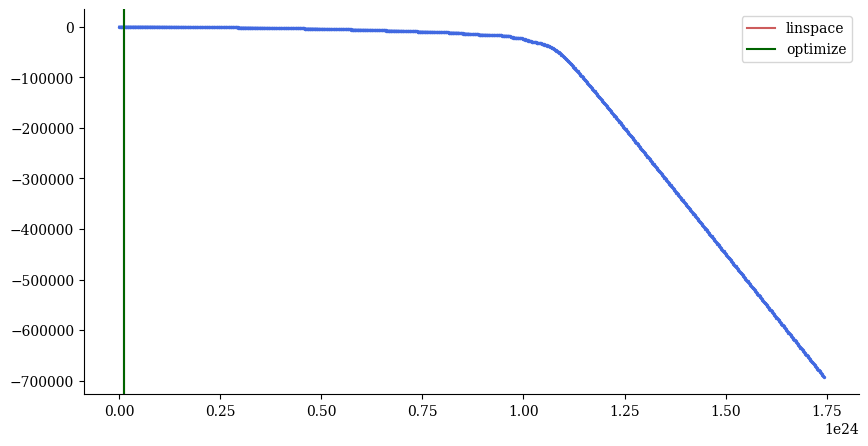

In [17]:
# NOTE In theory, this curve should be perfectly smooth and convex.
# However, it has a few bumps. These bumps don't detract from the
# convexity, but they do make it less smooth. The reason is that
# the slippage curves we set for `ExternalMarket`s are not perfectly
# smooth: they have small regions where slippage is constant despite
# increasing trade size. We discuss this more in `demo_slippage_curves.ipynb`,
# but it has to do with the fact that we use an IsotonicRegression to
# fit the slippage curve, whereas the "true" relationship is moreso a
# CenteredIsotonicRegression. This is a known issue, and we are working on it.

i = df["profit_optimize"].idxmax()
cycle = cycles[i]

trade = cycle.trades[0]

decimals = trade.pool.coin_decimals[trade.i]
address = trade.pool.coin_addresses[trade.i].lower()

# Set xatol
xatol = int(10**decimals / sample.prices_usd[address])

high = trade.pool.get_max_trade_size(trade.i, trade.j)
amts = np.linspace(1, high, 1000)
amts = [int(amt) for amt in amts]
profits = [cycle.populate(amt) for amt in amts]

best_amt_linspace = amts[np.argmax(profits)]
best_profit_linspace = max(profits)

# compare
best_amt_optimize, best_profit_optimize = cycle.optimize(xatol)

f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(amts, profits, color="royalblue", s=2)
ax.plot(amts, profits, color="royalblue")
ax.axvline(best_amt_linspace, color="indianred", label="linspace")
ax.axvline(best_amt_optimize, color="darkgreen", label="optimize")

# NOTE Uncomment to zoom into optimal region
# diff = abs(best_amt_optimize - best_amt_linspace)
# xlims = (float(min(best_amt_optimize, best_amt_linspace) - diff), float(max(best_amt_optimize, best_amt_linspace) + diff))
# tmp = [p for p, a in zip(profits, amts) if xlims[0] < a < xlims[1]]
# ylims = min(tmp), max(tmp)
# ax.set_xlim(*xlims)
# ax.set_ylim(*ylims)

ax.legend()

print(f"Best amount linspace: {best_amt_linspace}")
print(f"Best profit linspace: {best_profit_linspace}")
print(f"Best amount optimize: {best_amt_optimize}")
print(f"Best profit optimize: {best_profit_optimize}")

# Analyzing arbitrages

Now we show our arbitrage agent arbitraging all pools until there is no profitable arbitrage left.

In [7]:
cycles_ = cycles.copy()

with cProfile.Profile() as pr:
    results = arbitrageur.find_best_arbitrage(cycles_, sample)

stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.CUMULATIVE)
stats.print_stats()

         26074 function calls (25962 primitive calls) in 0.010 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.010    0.010 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/agents/arbitrageur.py:75(find_best_arbitrage)
       56    0.000    0.000    0.010    0.000 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/trades/cycle.py:139(optimize)
      168    0.000    0.000    0.007    0.000 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/venv/lib/python3.11/site-packages/crvusdsim/pool/crvusd/price_oracle/crypto_with_stable_price/base.py:177(price_w)
      113    0.000    0.000    0.006    0.000 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/venv/lib/python3.11/site-packages/crvusdsim/pool/crvusd/price_oracle/aggregate_stable_price.py:216(price)
      113    0.001    0.000    0.006    0.000 /Users/tncintra/Desktop/root/xenophon

In [8]:
best_cycle, best_profit = results
best_cycle, best_profit

(Cycle(Trades: [Swap(pool=Curve.fi Stablecoin WETH, in=WETH, out=crvUSD, amt=156636644777976561664), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=crvUSD, out=TUSD, amt=394762831001139811443035), Swap(pool=External Market (TUSD, WETH), in=TrueUSD, out=Wrapped Ether, amt=395186285539737954901019)], Expected Profit: 6.263575702889857),
 15213.6616605062)

In [9]:
arbitrageur.arbitrage(cycles, sample)  # change log level to DEBUG to see the trades

### A Quant Might Ask

Why is there such a profitable arbitrage opportunity? Does that not violate the no-arbitrage condition?

It does. But the answer is: crvUSD pool snapshots and stableswap pool snapshots are taken at different times. This means the pools are mispriced by construction! The LLAMMA price is based on the "oracle price" and the bands snapshots taken by the subgraph. The stableswap prices are based on a separate snapshot taken by a separate subgraph service. Finally, the External Markets are all set to the "current" prices from Coingecko. 

For our risk simulations, this means that our "setup" period should include an initial round of arbitrages to equilibrate all pool prices.